# Online Shopper Purchase Activity Prediction Using Keras MLP

### Import Libraries

In [15]:
#Import related libraries
import os
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from pandas.api.types import CategoricalDtype
from sklearn.metrics import f1_score,make_scorer
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Dropout
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint,EarlyStopping
seed = 1234
np.random.seed(seed)
pd.set_option('mode.chained_assignment', None)

### Utility Functions

In [2]:
#Utility function
def onehot_features(df,trainingSet,features, sparse=False, dummy_na=True):
    features = [f for f in features if f in trainingSet.columns]
    for column in features:
        categories = trainingSet[column].dropna().unique()
        df[column] = df[column].astype(CategoricalDtype(categories=categories,ordered=True))
    df = pd.get_dummies(df,columns=features, dummy_na=dummy_na,sparse=sparse)
    return df

def createModel(hiddenNodes,dropOutVal,optimizerVal, featureNum):
    #Write your model structure
    #Hint: Use Sequential(), Dense(), DropOut(), model.add   ..... 
    #First Dense Layer need to have input_dim equals to the number of features, which is the value of parameter featureNum
    #Be aware of type conversion for hiddenNodes/2
    
    
    
    
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizerVal, metrics=['accuracy'])
    return model

sampleModel = createModel(10,0.1,'adam',32)
sampleModel.summary()

### Data Preprocessing

In [3]:
#Read in data
filePath = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
dataframe = pd.read_csv(filePath)
#Observe loaded data
dataframe.iloc[0:5,:]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
targetColumn = ['revenue']
featureExclude = []
#Lowercase columns
dataframe.columns = dataframe.columns.str.lower()
dataframe[targetColumn] = dataframe[targetColumn].astype(int)
#Remove columns having constant values
uniqueValColumns = [c for c in list(dataframe) if len(dataframe[c].unique())==1]
#Dummy variables
dummyVariables = ['Month','VisitorType','Weekend']
dummyVariables = [item.lower() for item in dummyVariables]
numericFeatures = [col for col in dataframe.select_dtypes('number').columns if col not in dummyVariables]
#Fill blank values
dataframe[numericFeatures].fillna(0,inplace=True)

featureColumns = [col for col in dataframe.columns if col not in featureExclude+targetColumn+uniqueValColumns]

dataframeCopy = dataframe.copy()[featureColumns+targetColumn]
dataframeCopy = onehot_features(dataframeCopy,dataframeCopy,dummyVariables)
featureColumnsWithDummy = [col for col in dataframeCopy.columns if col not in targetColumn]

### Training and testing data preparation

In [5]:
#90% 10% Split for training_valid & testing
X_train_valid, X_test, y_train_valid, y_test = train_test_split(dataframeCopy[featureColumnsWithDummy], dataframeCopy[targetColumn], test_size = 0.1, random_state = 1234)

In [10]:
print(X_train_valid.shape)
print(X_test.shape)

(11097, 32)
(1233, 32)


In [6]:
#Scaling feature values
X_scaler = MinMaxScaler()
X_scaler.fit(X_train_valid)
X_train_valid = X_scaler.transform(X_train_valid)
X_test = X_scaler.transform(X_test)
#90% 10% Split for training & validation set(used for early stopping)
X_train,X_valid,y_train,y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.1, random_state = 1234)

In [7]:
# define 5-fold cross validation test harness
nfolds = 5
hiddenNodeList = [64,128]
batch_sizeList = [16,32]
dropOutList = [0.1,0.2]
epochs = [50,100]
optimizerValList = ['adam']
param_grid = dict(batch_size=batch_sizeList, epochs=epochs, hiddenNodes = hiddenNodeList, dropOutVal = dropOutList,optimizerVal=optimizerValList, featureNum =[X_train_valid.shape[1]])
modelCV = KerasClassifier(build_fn=createModel, verbose=0)

### Model Training - CV

In [8]:
#scores = ['precision', 'recall']
scores = ['f1']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    rs = GridSearchCV(
        estimator=modelCV,
        param_grid=param_grid, 
        cv=nfolds,
        scoring='%s_macro' % score,
        verbose=2
    )

    print(rs)
    fitted_model = rs.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (fitted_model.best_score_, fitted_model.best_params_))
    print()

# Tuning hyper-parameters for f1

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001A4AB02E7C8>,
             param_grid={'batch_size': [16, 32], 'dropOutVal': [0.1, 0.2],
                         'epochs': [50, 100], 'featureNum': [32],
                         'hiddenNodes': [64, 128], 'optimizerVal': ['adam']},
             scoring='f1_macro', verbose=2)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam 
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total= 1.1min
[CV] batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total= 1.1min
[CV] batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam 
[CV]  batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total= 1.1min
[CV] batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam 
[CV]  batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total= 1.1min
[CV] batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam 
[CV]  batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total= 1.1min
[CV] batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=128, optimizerVal=adam 
[CV]  batch_size=16, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=128, optimizerVal=adam, total= 1.1min
[CV] batch_size=16, dropOutVal=0.1, epochs=50, fea

[CV]  batch_size=32, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total=  54.4s
[CV] batch_size=32, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam 
[CV]  batch_size=32, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total=  55.1s
[CV] batch_size=32, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam 
[CV]  batch_size=32, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total=  55.8s
[CV] batch_size=32, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam 
[CV]  batch_size=32, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total=  57.8s
[CV] batch_size=32, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam 
[CV]  batch_size=32, dropOutVal=0.1, epochs=50, featureNum=32, hiddenNodes=64, optimizerVal=adam, total=  56.2s
[CV] batch_size=32, dropOutVal=0.1, epochs=50, featu

[CV]  batch_size=32, dropOutVal=0.2, epochs=100, featureNum=32, hiddenNodes=128, optimizerVal=adam, total= 2.5min


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 145.8min finished


Best: 0.790532 using {'batch_size': 32, 'dropOutVal': 0.2, 'epochs': 50, 'featureNum': 32, 'hiddenNodes': 64, 'optimizerVal': 'adam'}



### Model Training - Standalone

In [21]:
#Best: {'batch_size': 32, 'dropOutVal': 0.2, 'epochs': 50, 'featureNum': 32, 'hiddenNodes': 64, 'optimizerVal': 'adam'}
model = createModel(64,0.2,'adam',X_train_valid.shape[1])
model.summary()
earlyStopPatience = 50
earlyStop = EarlyStopping(monitor='val_loss',patience=earlyStopPatience, verbose=0)
mc = ModelCheckpoint('model/best_model.h5',monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    validation_data=[X_valid,y_valid],
                    batch_size=32, 
                    callbacks=[earlyStop,mc], 
                    verbose=1)


Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_253 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_169 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_254 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_170 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_255 (Dense)            (None, 1)                 33        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________
Train on 9987 samples, validate on 1110 samples
Epoch 1/100
9987/9987 [==============================] - 5s 453us/ste

Epoch 49/100
9987/9987 [==============================] - 2s 208us/step - loss: 0.2124 - accuracy: 0.9109 - val_loss: 0.2369 - val_accuracy: 0.9000
Epoch 50/100
9987/9987 [==============================] - 2s 220us/step - loss: 0.2100 - accuracy: 0.9105 - val_loss: 0.2363 - val_accuracy: 0.8946
Epoch 51/100
9987/9987 [==============================] - 2s 230us/step - loss: 0.2097 - accuracy: 0.9091 - val_loss: 0.2351 - val_accuracy: 0.8982
Epoch 52/100
9987/9987 [==============================] - 2s 231us/step - loss: 0.2125 - accuracy: 0.9103 - val_loss: 0.2372 - val_accuracy: 0.8982
Epoch 53/100
9987/9987 [==============================] - 2s 232us/step - loss: 0.2089 - accuracy: 0.9128 - val_loss: 0.2360 - val_accuracy: 0.9018
Epoch 54/100
9987/9987 [==============================] - 3s 255us/step - loss: 0.2102 - accuracy: 0.9081 - val_loss: 0.2398 - val_accuracy: 0.8973
Epoch 55/100
9987/9987 [==============================] - 2s 226us/step - loss: 0.2113 - accuracy: 0.9127 - val_

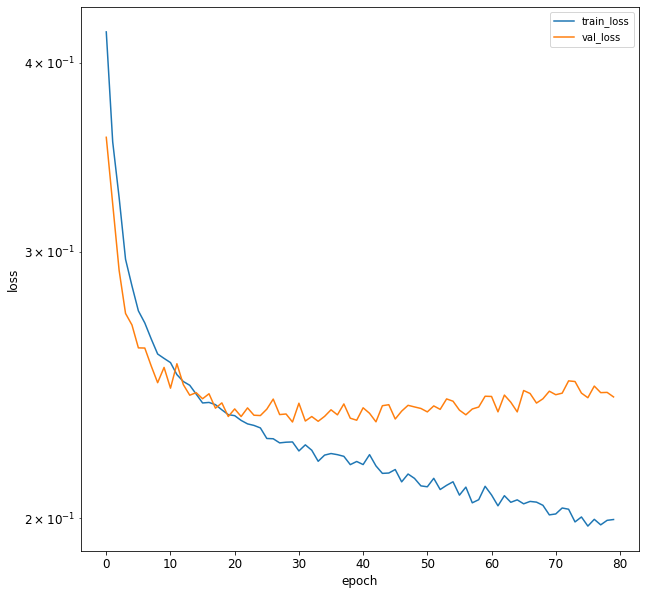

In [22]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'],'val_loss':history.history['val_loss']})
plot_df.plot(logy=True,figsize=(10,10),fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.show()

In [23]:
model = load_model('model/best_model.h5')
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1041
           1       0.71      0.60      0.65       192

    accuracy                           0.90      1233
   macro avg       0.82      0.78      0.80      1233
weighted avg       0.90      0.90      0.90      1233

